# PyRV32 - a RISCV compatible CPU

**Pyrv32 package required!**


## Preparing/Configuring

In [1]:
import sys
sys.path.append("../../pyrv32")
sys.path.insert(0, "/home/pyosys/src/myhdl/myhdl-local")

## Overview

1. [Configuring the CPU](riscv/config.ipynb)
+  [Arithmetic/Logic Unit tests](riscv/alu.ipynb)
+  [Instruction decoder](riscv/instruction.ipynb)

In [2]:
class MyEvent:
    def __init__(self):
        self.brk = Signal(bool(0))         # Break event
        self.dbgbreak = Signal(bool(0))    # Debug breakpoint condition
        self.busy = Signal(bool(0))        # Busy signal
        self.hold = Signal(bool(0))        # Hold signal
        self.emuack = Signal(bool(0))      # Emu acknowledge
        self.emuexec = Signal(bool(0))     # Emu IR execute
        self.emumask = Signal(bool(0))     # Emulation mask
        self.override = Signal(bool(0))    # IRQ override signal
        self.cpustat = Signal(intbv()[8:]) # CPU state register



class MyRiscVEvent(MyEvent):
    def __init__(self):
        Event.__init__(self)
        self.reset = ResetSignal(0, 1, False)
        self.idle = Signal(bool(0))  # Request idle (wait for IRQ)
        self.exception = Signal(bool(0))  # General external Exception signal
        self.irq  = Signal(bool(0))  # General IRQ signalled
        self.vector = Signal(ProgAddr())  # External event vector
        self.rete = Signal(bool(0))  # Return from emulation issued
        self.reti = Signal(bool(0))  # Return from interrupt issued
        self.stall = Signal(bool(0))  # Pipeline stall
        self.membusy = Signal(bool(0))  # memory read busy
        self.data_valid = Signal(bool(0))  # (LOAD) data_valid ready
        self.dbg_wr = Signal(bool(0))  # Write to debug register (outside emulation)
        # These are now (externally communicated) exception signals:
        # self.illegal = Signal(bool(0))  # Illegal instruction

        self.irqlatch0 = Signal(bool(0))   # IRQ latch
        self.irqack = Signal(bool(0))      # IRQ acknowledge
        
        
        self.saveret = Signal(bool(0))  # TESTING


## Core test unit

In [3]:
from myhdl import *

@block
def cpustate(clk, reset, de_en, evt, action, state):

    branch = Signal(bool(0))
    
    if CONFIG_EARLY_BRANCH_DETECTION:
        @always_comb
        def branch_evt():
            branch.next = action.branch

    else:
        @always(clk.posedge)
        def branch_evt():
            branch.next = action.branch

    
    @always_seq(clk.posedge, reset)
    def state_worker():
        """Complex state machine using DELAY/shortcut pipeline implementation
Handles CPU state and program flow.
TODO: Simplify, use separate delay state."""
        # Priorisation:

        action.emuexec.next = evt.emuexec
        #saveret = 0 # default
        trigger_hold = evt.hold or evt.brk

        if state == t_state.S_RESET:
            state.next = t_state.S_EXEC
        elif state == t_state.S_EXEC:
            # Emulation event has highest priority:
            if trigger_hold == 1:
                if evt.membusy:
                    state.next = t_state.S_WAIT
                elif not evt.busy:
                    state.next = t_state.S_HOLD
            elif action.branch == 1:
                state.next = t_state.S_BRANCH_SYNC
            elif evt.irqlatch0 and de_en and not evt.emuack:
                #saveret = 1
                if evt.membusy:
                    state.next = t_state.S_EVT_DELAY
                else:
                    state.next = t_state.S_EVT
            elif evt.idle == 1:
                #saveret = 1
                state.next = t_state.S_IDLE
            elif evt.membusy:
                # delayed pipeline mode:
                state.next = t_state.S_DELAY
        elif state == t_state.S_DELAY:
            # The earliest safe occasion to snap out of
            # the DELAY mode is at a branch, otherwise we'd have to stall.
            # This is because the WB stage experiences a delay as well.
            if trigger_hold == 1:
                if evt.membusy:
                    state.next = t_state.S_WAIT
                elif not evt.busy:
                    state.next = t_state.S_HOLD_DELAY
            elif action.branch == 1:
                state.next = t_state.S_BRANCH_DELAY
            elif evt.irqlatch0 and de_en and not evt.emuack:
                state.next = t_state.S_EVT_DELAY
                #saveret = 1
            elif evt.idle == 1:
                #saveret = 1
                state.next = t_state.S_IDLE
        elif state == t_state.S_WAIT:
            if evt.data_valid == 1:
                state.next = t_state.S_HOLD_DELAY
        elif state == t_state.S_HOLD_DELAY:
            if evt.hold == 0:
                state.next = t_state.S_RESUME
        elif state == t_state.S_BRANCH_SYNC:
            if trigger_hold == 1:
                state.next = t_state.S_HOLD
            elif evt.idle == 1:
                state.next = t_state.S_IDLE
            # We got an irq latched, but not yet acknowledged:

            elif evt.irqlatch0 and not evt.irqack:
                #saveret = 1
                state.next = t_state.S_EVT
            elif de_en == 1:
                state.next = t_state.S_EXEC

        elif state == t_state.S_BRANCH_DELAY:
            if trigger_hold == 1:
                state.next = t_state.S_HOLD_DELAY
            elif evt.idle == 1:
                state.next = t_state.S_IDLE
            elif evt.irqlatch0 and not evt.irqack:
                state.next = t_state.S_EVT_DELAY
                #saveret = 1
            elif de_en == 1:
                state.next = t_state.S_EXEC

        elif state == t_state.S_HOLD:
            if evt.hold == 0:
                state.next = t_state.S_RESUME
        elif state == t_state.S_RESUME:
            state.next = t_state.S_EXEC
        elif state == t_state.S_EVT:
            if branch == 1:
                state.next = t_state.S_BRANCH_SYNC
            elif not evt.stall:
                if evt.membusy == 1:
                    state.next = t_state.S_IRQ_DELAY
                else:
                    state.next = t_state.S_IRQ
        elif state == t_state.S_EVT_DELAY:
            if branch == 1:
                state.next = t_state.S_BRANCH_DELAY
            elif not evt.stall:
                state.next = t_state.S_IRQ_DELAY
        elif state == t_state.S_IRQ:
            state.next = t_state.S_BRANCH_SYNC
        elif state == t_state.S_IRQ_DELAY:
            state.next = t_state.S_BRANCH_DELAY
        # Exception state currently not covered:
        elif state == t_state.S_IDLE:
            if evt.irq == 1:
                state.next = t_state.S_IRQ
        else:
            state.next = t_state.S_IDLE
            if __debug__:
                raise ValueError("Unhandled state %s" % repr(state))

                
    return instances()

In [4]:

from pyrv32_types import *
from pyrv32_exec import execute, Action
from core import fetch, decode, Hazard, RegDataPort, RegAddrPort
from tap import Tap
from memmgr import memio

@block
def test_core(clk, reset):
    ibranch, branch = [ Signal(bool(0)) for i in range(2) ]
    newpc, curpc, expc, depc = [ Signal(ProgAddr()) for i in range(4) ]
    fe_en, de_en, ex_en = [ Signal(bool(0)) for i in range(3) ]
    insn, prev_insn = [ Signal(Instruction()) for i in range(2) ]
    ibranch, branch = [ Signal(bool(0)) for i in range(2) ]
    event = Signal(bool(0))
    mode = Signal(t_mode.NOP)
    func = Signal(intbv(0)[3:0])
    imm = Signal(bv32())
    reg = RegAddrPort()
    action = Action()
    state = Signal(t_state.S_RESET)

    
    s3_evt = MyRiscVEvent()
    s3_haz = Hazard()
    s3_rdata = RegDataPort()
    sh = Signal(RegFileAddr(0)) # immediate shift value
    memport = MemIOPort()

    tap = Tap() # Dummy TAP


    # Currently local
    imem = ImemPort(config.CONFIG_ADDR_WIDTH)
    dmem = IOmemPort(config.CONFIG_ADDR_WIDTH)


    s1_fetch = fetch(clk, reset, fe_en, imem.iaddr, ibranch, newpc, curpc)
    s2_decode = decode(clk, insn, de_en, event, mode, func, imm, reg, action)
    s3_execute = execute(clk, reset, ex_en, mode, func, action, s3_evt, s3_haz, s3_rdata, imm, sh, memport, tap, expc, newpc)
    s2_s4_memio = memio(clk, action, dmem, imem, memport)
    
    
    trigger_hold = Signal(bool(0))

    inst_cpustate = cpustate(clk, reset, de_en, s3_evt, action, state)

    @always_comb
    def common():
        is_exception = state == t_state.S_EVT or state == t_state.S_EVT_DELAY
        is_branch = branch or is_exception
        
        trigger_hold.next = s3_evt.hold or s3_evt.brk

        ibranch.next = is_branch

    return instances()

## Synthesize

In [12]:
from core import Hazard, MemIOPort
from pyrv32_types import ExcSignals
from tap import Tap
from ramio import DmemPort, ImemPort, IOmemPort
import config
from myhdl.conversion import yshelper


def convert():
    clk = Signal(bool(0))
    reset = ResetSignal(0, 1, False)
    exsig = ExcSignals()
    tap = Tap()
    imem = ImemPort(config.CONFIG_ADDR_WIDTH)
    dmem = IOmemPort(config.CONFIG_ADDR_WIDTH)

    pyrv32 = test_core(clk, reset)
    design = yshelper.Design("top")
    pyrv32.convert("yosys_module", design, name="pyrv32", trace=True)
    return design
    
design = convert()
design.finalize("top")

CREATE Module: 'pyrv32'
Adding module with name: test_core_1_1
CONVERT_RTL tree >>>>>> 'PYRV32_COMMON' 
++++++++  fetch_1_1_1_20_1_15_15  ++++++++
unconnected (internal) wire nextpc
unconnected (internal) wire pc
Legacy class reg
Legacy class action
++++++++  decode_1_32_1_1_5_3_32  ++++++++
Unused signal: event
unconnected (internal) wire pc_func
unconnected (internal) wire pc_imm
unconnected (internal) wire pc_mode
unconnected (internal) wire de_action_swbrk
unconnected (internal) wire de_action_srcpc
unconnected (internal) wire de_action_aop
unconnected (internal) wire de_action_lmode
unconnected (internal) wire de_action_immediate
unconnected (internal) wire de_action_wreg
Unused port: de_action_wreg
Legacy class action
Legacy class evt
Legacy class haz
Legacy class reg
Legacy class mem
Legacy class tap
++++++++  execute_1_1_1_5_3_32_5_15_15  ++++++++
Unused signal: imm12
Unused signal: lock_io
unconnected (internal) wire alu_en
unconnected (internal) wire branch
unconnected (inter

CREATE Module: 'execute_1_0'
Legacy class action
Legacy class evt
Legacy class haz
Legacy class reg
Legacy class mem
Legacy class tap
Adding module with name: execute_1_1_1_5_3_32_5_15_15
CONVERT_RTL tree >>>>>> 'PYRV32_EXECUTE_1_0_MEPC_ASSIGN' 
CONVERT_RTL tree >>>>>> 'PYRV32_EXECUTE_1_0_CSR_ASSIGN' 
CONVERT_RTL tree >>>>>> 'PYRV32_EXECUTE_1_0_ASSIGN' 
MUX WALK DRV >>>: ../../pyrv32/pyrv32_exec.py:112 action_reg_we
CONVERT_RTL tree >>>>>> 'PYRV32_EXECUTE_1_0_BYPASS' 
MUX WALK DRV >>>: ../../pyrv32/pyrv32_exec.py:123 rs1
MUX WALK DRV >>>: ../../pyrv32/pyrv32_exec.py:122 rs1
MUX WALK DRV >>>: ../../pyrv32/pyrv32_exec.py:135 rs2
MUX WALK DRV >>>: ../../pyrv32/pyrv32_exec.py:134 rs2
CONVERT_RTL tree >>>>>> 'PYRV32_EXECUTE_1_0_MUX' 
MUX WALK DRV >>>: ../../pyrv32/pyrv32_exec.py:149 mux_a
MUX WALK DRV >>>: ../../pyrv32/pyrv32_exec.py:154 mux_sh
MUX WALK DRV >>>: ../../pyrv32/pyrv32_exec.py:154 mux_b
MUX WALK DRV >>>: ../../pyrv32/pyrv32_exec.py:166 branch_pc
CONVERT_RTL tree >>>>>> 'PYRV32_

CREATE Module: 'memio_1_0'
Legacy class act
Legacy class dmem
Legacy class imem
Legacy class memport
Adding module with name: memio_1
CONVERT_RTL tree >>>>>> 'PYRV32_MEMIO_1_0_IMEM_DATA_SELECT' 
MUX WALK DRV >>>: ../../pyrv32/memmgr.py:32 is_imem
MUX WALK DRV >>>: ../../pyrv32/memmgr.py:38 data_mux
CONVERT_RTL tree >>>>>> 'PYRV32_MEMIO_1_0_IMEM_DATA_ACCESS_REGISTER' 
CONVERT_RTL tree >>>>>> 'PYRV32_MEMIO_1_0_IMEM_DATA_ACCESS' 
CONVERT_RTL tree >>>>>> 'PYRV32_MEMIO_1_0_IMEM_DATA_WR_ACCESS' 
CONVERT_RTL tree >>>>>> 'PYRV32_MEMIO_1_0_ASSIGN' 
CONVERT_RTL tree >>>>>> 'PYRV32_MEMIO_1_0_WORKER' 
MUX WALK DRV >>>: ../../pyrv32/memmgr.py:108 mode_d
DONE instancing submodules
CREATE Module: 'cpustate_0_0'
Legacy class evt
Legacy class action
Adding module with name: cpustate_1_1_1_4
CONVERT_RTL tree >>>>>> 'PYRV32_CPUSTATE_0_0_BRANCH_EVT' 
CONVERT_RTL tree >>>>>> 'PYRV32_CPUSTATE_0_0_STATE_WORKER' 
MUX WALK DRV >>>: <ipython-input-3-84b26393a7f4>:35 state
MUX WALK DRV >>>: <ipython-input-3-84b2

Generating RTL image...
Display...


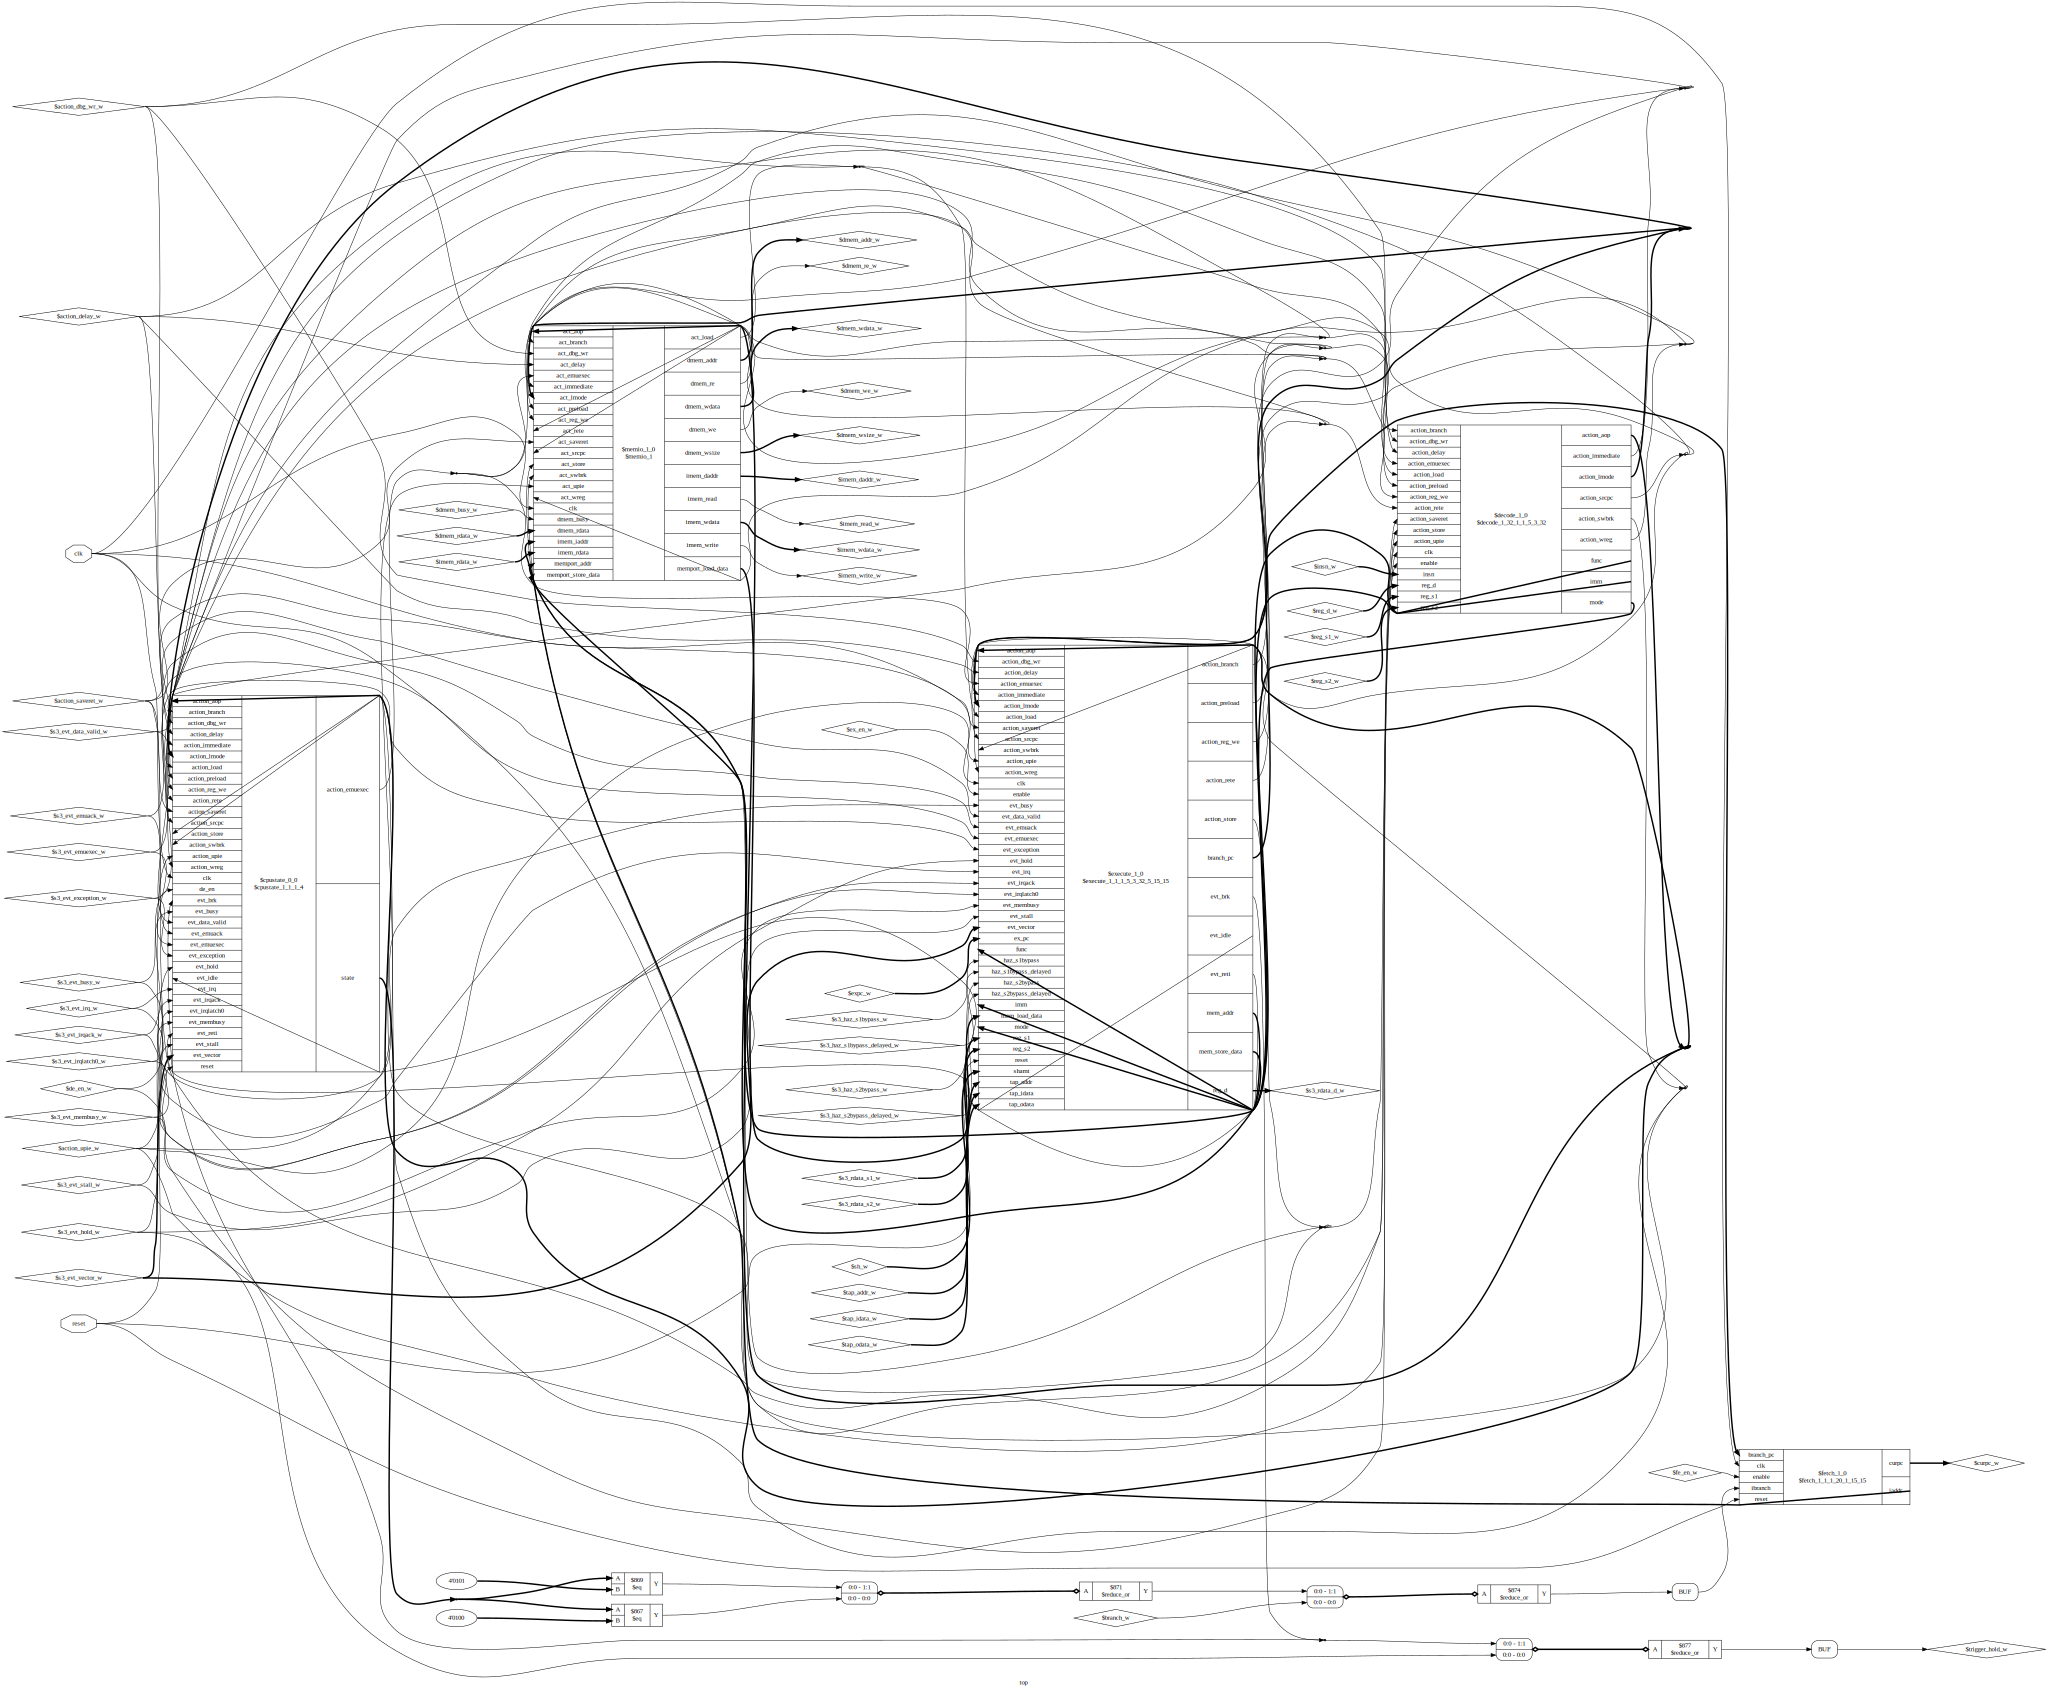

In [13]:
from ys_aux import to_svg
sys.path.append("..")
#design.run("flatten; clean; opt")
display(to_svg(design, "top", 400))
# from ecp5aux import synthesize
design.d
# synthesize(design)

# json_filename = "riscv.json"

# design.run("write_json %s" % json_filename)

## Verification

First, we configure some virtual RAM using a dictionary.

In [7]:
ram_data0 = {}
ram_data1 = {}
ram_data2 = {}
ram_data3 = {}

ram_data0[0x20] = 0xce
ram_data1[0x20] = 0xfa
ram_data2[0x20] = 0xad
ram_data3[0x20] = 0x0b

# SystemID code
p = 0x10000010
ram_data0[p] = 0xde
ram_data1[p] = 0xad
ram_data2[p] = 0xfa
ram_data3[p] = 0xce

# RAM bank proxy:
dmemory = [ram_data0, ram_data1, ram_data2, ram_data3]



Then we initialize the memory with a compiled program and print out all function symbols:

In [8]:
from loader import load_elf


PROGNAME = "/home/pyosys/src/myhdl/myhdl-local/example/ipynb/work/pyrv32/main.elf"

rom_data = list(range(2**CONFIG_BRAM_ADDR_WIDTH))

symbols = load_elf(PROGNAME, rom_data, dmemory, debug = False)
# Reverse lookup:
function_addresses =  {addr.st_value: sym for sym, addr in symbols.items() if addr.st_info == 18} 
print("====== Function addresses =====")
for a, n in function_addresses.items():
    print("%08x:      %s " % (a, n))

Got sym section .symtab
Got str section .strtab
====== Function addresses =====
00000140:      test_iomem 
000003e0:      test_const 
000001d8:      output 
0000007c:      func_b 
00000254:      sum 
00000094:      test_alu 
000004ec:      run_test 
00000234:      fill 
0000057c:      emulation 
0000027c:      casetest 
000002c8:      test_division 
00000338:      test 
000000a0:      test_ldst 
00000310:      arith_test 
0000008c:      func_d 
0000043c:      run_haz_load_coll 
00000320:      test_funcp 
000000ec:      test_irq_handler 
000005b0:      main 
000004c0:      test_last 
000001f4:      divide 
00000318:      functest 
000003fc:      test_load_hazard 
000001c4:      test_waitflag 
0000012c:      test_subsequent_access_hazard 
00000074:      func_a 
00000430:      mem_reset 
00000484:      test_haz_load_coll 
00000084:      func_c 
00000128:      exception_handler 


In [9]:
from core import pyrv32_cpu
from config import *
from riscv32_insn import *
from emulation import instruction_rom, io_emulation


@block
def test_pyrv32(mem_log, START, STOP):
    clk = Signal(bool(0))

    reset = ResetSignal(0, 1, isasync = False)
    
    imem = ImemPort(CONFIG_ADDR_WIDTH)
    dmem = IOmemPort(CONFIG_ADDR_WIDTH)

    exsig = ExcSignals()

    tap = Tap(Instruction(INSN_NOP))

    access_size = Signal(intbv(0, min=0, max=4))
    pcrel_addr = Signal(intbv(0, min=0, max=2**CONFIG_BRAM_ADDR_WIDTH))
    pcrel_data = Signal(bv32(0))

    data_addr = Signal(modbv(0)[CONFIG_BRAM_ADDR_WIDTH:])
    insn_addr = Signal(modbv(0)[CONFIG_BRAM_ADDR_WIDTH:])

    rom_inst = instruction_rom(clk, imem.ire, insn_addr, imem.idata, \
        pcrel_addr, pcrel_data, rom_data)
    cpu_inst = pyrv32_cpu(clk, reset, tap, exsig, imem, dmem, START)

    ram_inst = io_emulation(clk, dmem, LOG_PSEUDO_MMR, mem_log, dmemory)

    @always(delay(1))
    def clkgen():
        clk.next = not clk
        
    @always_comb
    def assign():
        insn_addr.next = imem.iaddr[:2]
        pcrel_addr.next = data_addr[:PC_ADDRESS_LSB] & \
            (2**CONFIG_BRAM_ADDR_WIDTH - 1)
        
    @instance
    def stimulus():
        reset.next = 1
        yield delay(10)
        reset.next = 0
        
        msg = "Abort"
        
        for i in range(20000):
            yield(clk.posedge)
            if tap.curpc == STOP:
                msg = "Completed"
                break
        print("Stop at PC %08x" % tap.curpc)
        raise StopSimulation(msg)
    
    return instances()

In [10]:
f = open("/tmp/rv32.log", "w")

startaddr = symbols['_start'].st_value
stopaddr = symbols['terminate_emulation'].st_value

tb = test_pyrv32(f, startaddr, stopaddr)
tb.config_sim(backend = 'myhdl', timescale="1ps", trace=True)
tb.run_sim()
tb.quit_sim()

f.close()

Stop at PC 00000018


<class 'myhdl.StopSimulation'>: Completed


### Dump logged MMR accesses

The virtual console is logged into this file:

In [11]:
! cat /tmp/rv32.log